When I first started getting into machine learning, one of the techniques that always blew my mind was **Neural Style Transfer**. NST was [first described](https://arxiv.org/pdf/1508.06576.pdf) by Gatys et. al in 2015, but I originally learned about it through [this wonderful 2 minute papers video](https://www.youtube.com/watch?v=HTUxsrO-P_8). 

Neural style transfer is a technique for doing **style transfer**, where we combine the **content** of one image with the **style** of another image. Look at these examples from the paper below.

![nst.png](nst.png)

I am incredibly amazed with these results, and was excited to be able to try to reproduce them. 

Months after I first learned about neural style transfer, friends started downloading an app called Prisma, which offered artistic "filters" for your images. The effect was unmistakable. Prisma was putting neural style transfer in the hands of the public! Unfortunately Prisma is no longer free, but in this post we will dig into the details so you can reproduce the same effects yourself!

To produce an output image, we need two input images: a **content image** $I_c$ and a **style image** $I_s$. The content image represents what we might think of as the physical elements of the image. The style image represents how those elements are stylistically rendered. For example, in the above images from the paper, the content image is a riverside shot of Amsterdam, and the style images are Van Gogh's *The Starry Night* and Edvard Munch's *The Scream*.

Neural style transfer begins with a white noise image $I$. The image is then simultaneously optimized to minimize two losses: the **content loss** and the **style loss**.

## Content Loss

The content loss, denoted $\mathcal{L}_c(I, I_c)$, measures the difference in content between $I$ and $I_c$. A trivial way to define this would just be the pixel-wise squared error:
$$
\mathcal{L}_c = \| I - I_c \|_F^2 = \sum_{i, j} \left( I_{i, j} - I_{c_{i, j}} \right)^2
$$

However, it turns out that using this for the content loss is too powerful. By defining the loss on a pixel-by-pixel basis, we force the learned image to be pixelwise similar to the content image. However, this is not what we want. We just want the general structure of the content image to be preserved. 

The solution that the authors came up with was to look at the way that the image was represented by a convolutional neural network. As an image is processed by a convolutional neural network, the representation of the image becomes more and more abstract. Chris Olah's [publication on Distill](https://distill.pub/2017/feature-visualization/) demonstrates this effect. We call the representation of the image at layer $l$ the **features** or **feature map** of the image $F^l(I)$. 

To follow the paper, let's use the VGG19 convolutional neural network as a concrete example:

![vgg19.png](vgg19.png)

The diagram shows the dimensions of the feature map at each layer of the network. 

The idea is that we optimize the input image so that the features $F^l(I)$ match the features of the content image $F^l(I_c)$. The deeper into the network (the larger the value of $l$), the more abstract the representations become, and the less cohesive the reconstructed image becomes.

Thus, our content loss function becomes

$$
\mathcal{L}_c = \| F^l(I) - F^l(I_c) \|_F^2 = \sum_{i, j} \left( F^l(I)_{i,j} - F^l(I_c)_{i, j} \right)^2
$$

Below is a full implementation of this optimization process for different layers of VGG19. First we will need some PyTorch modules.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision.models import vgg19
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Below, we create our own neural network class by subclassing `torch.nn.Module`. We make use of the pretrained VGG19 model provided by the `torchvision.models` module. This model has a `features` attribute containing the convolutional layers of the network. We can make use of these in our `forward` method by simply iterating over them. We can keep track of all of the feature maps by adding them to a list. Some of the layers in `features` are convolutional layers (`torch.nn.Conv2d`), some are ReLU layers (`torch.nn.ReLU`) and some are MaxPooling layers (`torch.nn.MaxPool2d`). Based on the paper, we only care about the feature maps computed after convolutional layers, so we keep track of those. 

In [3]:
class Vgg19(nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        self.vgg19 = vgg19(pretrained=True).eval().to(device)
        
    def forward(self, x):
        features = []
        for layer in self.vgg19.features:
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                features.append(x)
        return features

We can make use of the `torchvision.transforms` module to create a function that preprocesses our images to make them compatible with the network. The inputs to the network must be of size $b \times 3 \times 224 \times 224$ where $b$ is the batch size. For this reason, we first resize images to $224 \times 224$ pixels. The inputs are also expected to be first normalized into the range (0, 1) and then normalized channel-wise according to a normal distribution with the means and standard deviations given below. Further details are available in the [documentation](https://pytorch.org/docs/stable/torchvision/models.html). Since the batch size is 1, we can call `unsqueeze` to add a dimension. We use the `Image` class from the `PIL` library to load and store images.

In [4]:
to_input = T.Compose([
    T.Resize((224, 224)), 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.unsqueeze(0).to(device)),
])

We also provide the inverse transformation so that we can convert from the PyTorch tensors we are optimizing to images we can visualize.

In [5]:
to_output = T.Compose([
    T.Lambda(lambda x: (x - x.min())/(x.max()-x.min())),
    T.Lambda(lambda x: x.squeeze().cpu()),
    T.ToPILImage()
])

The training loop is straightforward:
1. Compute the features of the content image
2. Initialize a white noise image and optimizer
3. Compute the features of the white noise image
4. Compute the loss between the features of the content image and the white noise image
5. Perform an optimization step to minimize the loss with respect to the white noise image
6. Repeat from step 3 until done.

In [6]:
def fit_content(model, content_image,
              content_layer=4,
              epochs=1000, lr=1e-1):

    content_features = model(content_image)
    
    img = 1e-1*torch.randn_like(content_image, device=device)
    img.requires_grad_(True)

    opt = torch.optim.Adam([img], lr=lr)

    for epoch in range(epochs):
        opt.zero_grad()
        
        features = model(img)
        
        content = features[content_layer]
        content_target = content_features[content_layer].detach()
        loss = ((content - content_target)**2).sum()
    
        loss.backward()
        opt.step()
        
    return to_output(img)

Let's look at the image we get when we optimize for progressively deeper layers of the network:

In [7]:
vgg19 = Vgg19()

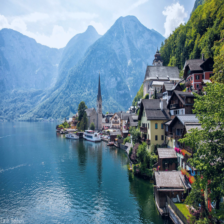

In [8]:
content_image = to_input(Image.open('hallstatt.jpg'))
to_output(content_image)

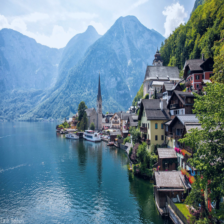

In [9]:
fit_content(vgg19, content_image, content_layer=0)

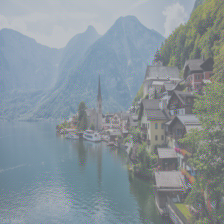

In [10]:
fit_content(vgg19, content_image, content_layer=2)

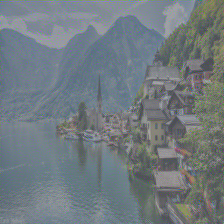

In [11]:
fit_content(vgg19, content_image, content_layer=4)

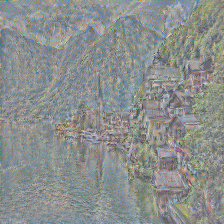

In [12]:
fit_content(vgg19, content_image, content_layer=8)

Because the network does convolution operations (which are non-invertible), there are many input images that can produce the same activations for a given layer. The deeper we go, the bigger the space becomes of input images that produce the same activations. The result is that only the general structure of the input image is maintained at deeper layers. Texture information is completely discarded.

## Style loss

Now let's turn our attention to the style loss. We want to define a loss function so that the style of our image $I$ matches the style of $I_s$. For the content loss, we minimized the difference between the features $F^l(I)$ and $F^l(I_c)$. For the style loss, we are going to do something similar.

The features computed for the content loss are based on operations that preserve information about location (convolution, ReLU and MaxPooling). We want something similar that does not preserve the location information. The trick is to use the features to compute a **Gram matrix**.

Imagine we have a feature map at layer $l$ of size $c \times h \times w$ (channels, height, width). First, vectorize the last two dimensions of the feature map to get a matrix of size $c \times hw$. Then perform the inner product (matrix multiplication) of this matrix with its transpose to get the Gram matrix.

The Gram matrix essentially computes the correlation between features for each channel $c$, giving us a $c \times c$ matrix. This computation destroys information about location while maintaining general information about features and abstract representations. 

We can then optimize our image $I$ to match the style of $I_s$ by minimizing the difference between the Gram matrix of their features at layer $l$:

$$
\mathcal{L}_s = \| G(F^l(I)) - G(F^l(I_s)) \|_F^2 = \sum_{i, j} \left( G(F^l(I))_{i, j} - G(F^l(I_s))_{i, j} \right)^2
$$

Below is an implementation of computing the gram matrix $G(F^l(I))$ given the features $F^l(I)$.

In [13]:
def gram_matrix(features):
    # first dimension is batch dimension
    _, c, h, w = features.size()
    features = features.view(c, h*w)
    return features@features.T

We can write an optimization loop similar to `fit_content` that optimizes instead for the style loss at different layers of the network:

In [14]:
def fit_style(model, style_image,
              style_layer=4,
              epochs=1000, lr=1e-1):

    style_features = model(style_image)
    
    img = 1e-1*torch.randn_like(style_image, device=device)
    img.requires_grad_(True)

    opt = torch.optim.Adam([img], lr=lr)

    for epoch in range(epochs):
        opt.zero_grad()
        
        features = model(img)
        
        style = gram_matrix(features[style_layer])
        style_target = gram_matrix(style_features[style_layer].detach())
        loss = ((style - style_target)**2).sum()
    
        loss.backward()
        opt.step()
        
    return to_output(img)

Like above, we can see how fitting to the style of an image at different layers changes the effects:

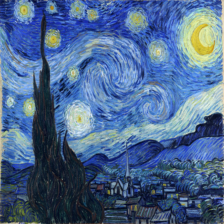

In [15]:
style_image = to_input(Image.open('starry-night.jpg'))
to_output(style_image)

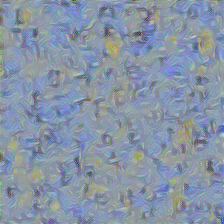

In [16]:
fit_style(vgg19, style_image, style_layer=1)

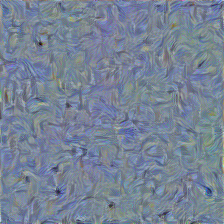

In [17]:
fit_style(vgg19, style_image, style_layer=2)

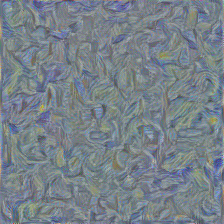

In [18]:
fit_style(vgg19, style_image, style_layer=3)

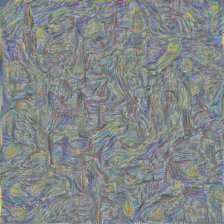

In [19]:
fit_style(vgg19, style_image, style_layer=4)

The different layers contain information about the texture of the style image at different scales. The earlier layers contain low-level details and the optimized image almost looks like brush strokes. The later layers look more "zoomed out" and contain structures like whorls and stars that are reminiscent of the overall style of the painting.

## Putting them together

The goal is to produce an image $I$ with the general content of $I_c$ and the style of $I_s$. To do this, we can simultaneously optimize for $\mathcal{L}_c$ and $\mathcal{L}_s$. The question remains, though - which layer(s) $l$ should I use for the content loss, and which should I use for the style loss?

The authors of neural style transfer found that the following give the best results:
1. A deeper layer for the content loss. This maintains the general structure of the image but does not force pixel values to be the same.
2. Multiple (early) layers for the style loss. By using multiple layers, we can get a cohesive style reproduction at multiple scales.

With these tips in mind, we can combine `fit_content` and `fit_style` to iterate over `style_layers` and `content_layers` to compute the total loss. We also need to have a technique for balancing out each of the style and content loss terms. Our overall loss looks like

$$
\mathcal{L} = \alpha \mathcal{L}_c + \beta \mathcal{L}_s
$$

where $\mathcal{L}_c$ is the content loss summed over all content layers and $\mathcal{L}_s$ is the style loss summed over all style layers, and $\alpha$ and $\beta$ control their weight respectively.

The authors also provide the option of weighting the loss for each layer, but in practice they just weight each layer equally. Below is a full implementation of neural style transfer using the style and content layers suggested by the authors.

In [27]:
def fit(model, style_image, content_image,
              style_weight=1e-2, content_weight=1e2,
              style_layers=[0, 1, 2, 3, 4], content_layers=[4],
              epochs=1000, lr=1e-1):
    
    content_features = model(content_image)
    style_features = model(style_image)
    
    img = 1e-1*torch.randn_like(style_image, 
                            device=device)
    
    img.requires_grad_(True)

    opt = torch.optim.Adam([img], lr=lr)

    for epoch in range(epochs):
        opt.zero_grad()
        
        features = model(img)
        
        content_loss = 0
        for layer in content_layers:
            content = features[layer]
            content_target = content_features[layer].detach()
            content_loss += ((content - content_target)**2).sum()

        style_loss = 0
        for layer in style_layers:
            style = gram_matrix(features[layer])
            style_target = gram_matrix(style_features[layer]).detach()
            style_loss += ((style - style_target)**2).sum()

        loss = content_weight*content_loss/len(content_layers) \
               + style_weight*style_loss/len(style_layers) \
    
        loss.backward()
        opt.step()
        
    return to_output(img)

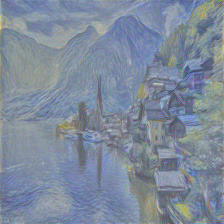

In [28]:
fit(vgg19, style_image, content_image)

## Comments on implementation

I found the implementation of this algorithm to be relatively easy. I could go from the paper to PyTorch code without much hassle.

I made some minor changes to the loss function for simplicity. Both the style and content losses included additional constant terms that were intended to make the gradients come out as a simple expression. However, since PyTorch does autograd extremely well, I decided that it was easier to just absorb those constants by changing the learning rate and by tweaking $\alpha$ and $\beta$.

When I initially started producing images, I couldn't reproduce the kinds of images I saw in the paper. However, I eventually realized that the issue was that my learning rate was too low. The default for `torch.optim.Adam` is $0.001$ which is way too small for this problem. As an example, here's the same code run with different learning rates:

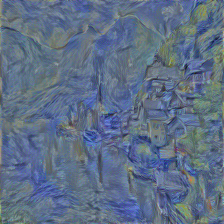

In [30]:
fit(vgg19, style_image, content_image, lr=1e-2)

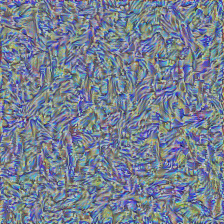

In [31]:
fit(vgg19, style_image, content_image, lr=1e-3)

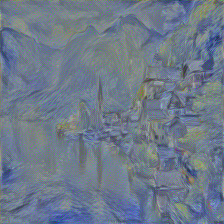

In [32]:
fit(vgg19, style_image, content_image, lr=1)

Like most machine learning, the "vanilla" version of this algorithm is quite sensitive. Other suggestions have been made to improve the stability of the algorithm, which are worth checking out. However, if you decide to implement this yourself or try something similar, don't forget the importance of hyperparameters.

For futher illustration, here's what happens when you change the content layer:

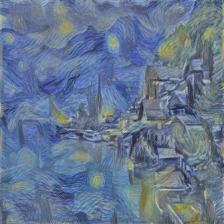

In [34]:
fit(vgg19, style_image, content_image, content_layers=[0])

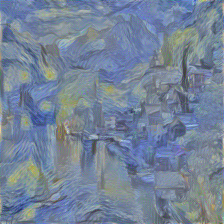

In [36]:
fit(vgg19, style_image, content_image, content_layers=[10])

The closer to the beginning the content layer is, the more details are reproduced. The farther from the beginning the content layers is, the less details are reproduced and the more abstract the result becomes.

You can also change the style and content weights. Here's what happens if you crank the content weight up by a factor of 10:

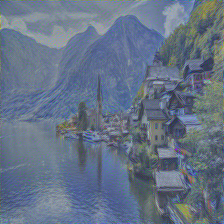

In [37]:
fit(vgg19, style_image, content_image, content_weight=1e3)

We can see that the details are much better preserved, but the artistic element is mostly lost.

Now if we reduce the content weight by a factor of 10:

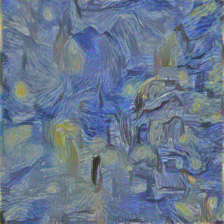

In [38]:
fit(vgg19, style_image, content_image, content_weight=1e1)

The result is quite abstract and it's hard to tell what the original content image was in the first place.

This algorithm is all about finding the right hyperparameters!

I hope you enjoyed reading this as much as I enjoyed implementing it.